<a href="https://colab.research.google.com/github/akadidas/Udacity_Project_Showcase/blob/master/Emotion_Based_Music_player_(Implemented_in_Pytorch)_Emotious.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Based Music player (Implemented in Pytorch) - Emotious

# Importing required Libraries and functions

In [0]:
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
from keras.preprocessing import image

Using TensorFlow backend.


In [0]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Checking For Cuda Availabilty

In [4]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Importing Required Dataset From Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Reading And Seperating Dataset For Train And Test Set

In [6]:
with open("/content/gdrive/My Drive/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


In [0]:
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("end")

In [8]:
print(x_train[0].shape)

(2304,)


In [0]:
#data transformation for train and test sets
x_train = torch.from_numpy(np.array(x_train, 'float32'))
y_train = torch.from_numpy(np.array(y_train, 'float32'))
x_test =torch.from_numpy(np.array(x_test, 'float32'))
y_test =torch.from_numpy(np.array(y_test, 'float32'))




# Transforming The Image Dataset

In [10]:
x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

print(x_train.shape[0])

x_train = x_train.view(x_train.shape[0],1, 48, 48)

x_test = x_test.view(x_test.shape[0],1, 48, 48)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#------------------------------

28709
28709 train samples
3589 test samples


In [11]:
print(x_train[1].shape)

torch.Size([1, 48, 48])


## Preparing  Train And Test Dataloader Using Dataloader Class 

In [12]:

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
size = 3589
train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(y_train).type(torch.LongTensor))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test), torch.tensor(y_test).type(torch.LongTensor))



train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)



# specify the image classes
classes = ['angry','disgust','fear','happy','sad','surprise,neutral']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


## Architecture For Convolutional Neural Network

In [13]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 48x48x1 image tensor)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        # convolutional layer (sees 24x24x32 tensor)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 12x12x64 tensor)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 6x6x128 tensor)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        # max pooling layer

        self.pool = nn.MaxPool2d(2, 2)
        #average pool layer
        self.Apool = nn.AvgPool2d(2, 2)

        # linear layer (256* 3* 3 -> 500)
        self.fc1 = nn.Linear(256* 3* 3, 500)
        # linear layer (500 -> 7)
        self.fc2 = nn.Linear(500, 7)
        # dropout layer (p=0.1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 256 * 3 * 3)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        
        
        return x

# create a complete CNN
model = Net()


model.cuda()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Apool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2304, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=7, bias=True)
  (dropout): Dropout(p=0.2)
)

## Optimizer And Criterion For Loss

In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training The Network

In [15]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu: 
            data, target = data.cuda(), target.cuda()

           
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_dataset)
    valid_loss = valid_loss/len(test_dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'emotion.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.759161 	Validation Loss: 1.618720
Validation loss decreased (inf --> 1.618720).  Saving model ...
Epoch: 2 	Training Loss: 1.486039 	Validation Loss: 1.401021
Validation loss decreased (1.618720 --> 1.401021).  Saving model ...
Epoch: 3 	Training Loss: 1.308952 	Validation Loss: 1.302168
Validation loss decreased (1.401021 --> 1.302168).  Saving model ...
Epoch: 4 	Training Loss: 1.201535 	Validation Loss: 1.240128
Validation loss decreased (1.302168 --> 1.240128).  Saving model ...
Epoch: 5 	Training Loss: 1.118455 	Validation Loss: 1.222147
Validation loss decreased (1.240128 --> 1.222147).  Saving model ...


## Testing The Network

In [16]:
correct = 0
total = 0
count=0
with torch.no_grad():
    for data,target in test_loader:
        data, target = data.cuda(), target.cuda()
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 52 %


## Function For Drawing Bar Graph Using Network Output

In [0]:
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    res=objects[np.argmax(emotions)]
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
    return res

# Testing Emotions On Some Images

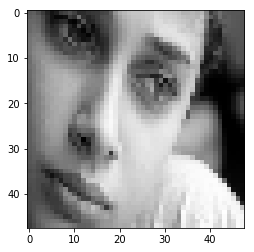

In [18]:

img = image.load_img("/content/gdrive/My Drive/pics/saa.jpg",color_mode = "grayscale", target_size=(48, 48))
img= image.img_to_array(img)
img1 = np.array(img, 'float32')
img = np.array(img, 'float32')
img /= 255
img = torch.from_numpy(img)
img = img.view(1,1, 48, 48)
img =img.cuda()

x= img1
x = x.reshape([48, 48]);
plt.gray()
plt.imshow(x)



custom is
tensor([[-0.4299, -4.2976,  0.5037, -0.7521,  1.8733, -1.8672,  1.2270]],
       device='cuda:0', grad_fn=<AddmmBackward>)
Custom after moving to cpu
tensor([[-0.4299, -4.2976,  0.5037, -0.7521,  1.8733, -1.8672,  1.2270]],
       grad_fn=<CopyBackwards>)
custom after np
[-0.42986587 -4.2976413   0.5037109  -0.7520521   1.873256   -1.8671998
  1.2270458 ]


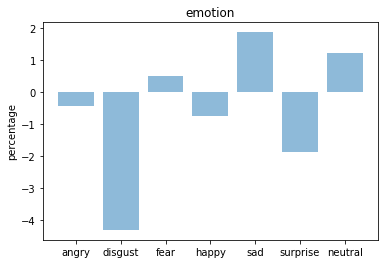

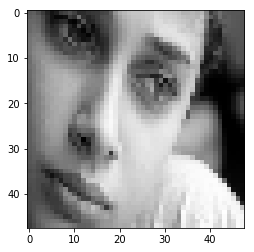

In [19]:
custom = model.forward(img)
print('custom is')
print(custom)
custom = custom.cpu()
print("Custom after moving to cpu")
print(custom)
custom = custom.detach().numpy()
print('custom after np')
print(custom[0])
res=emotion_analysis(custom[0])
res=res+".mp3"
x= img1
x = x.reshape([48, 48]);
plt.gray()
plt.imshow(x)
plt.show()
ipd.Audio(filename='/content/gdrive/My Drive/Songs/{}'.format(res),autoplay=True)


## Federated Learning

In [20]:
!pip install syft

In [21]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

W0820 22:36:58.437116 139640358672256 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0820 22:36:58.456949 139640358672256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [24]:
size = len(train_loader)

bobs_data = sy.BaseDataset(torch.tensor(x_train[:size//2]).type(torch.LongTensor), torch.tensor(y_train[:size//2]).type(torch.LongTensor)).send(bob)
alices_data = sy.BaseDataset(torch.tensor(x_train[size//2+1:]).type(torch.LongTensor), torch.tensor(y_train[size//2+1:]).type(torch.LongTensor)).send(alice)
federated_train_dataset = sy.FederatedDataset([bobs_data, alices_data])
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test).type(torch.LongTensor), torch.tensor(y_test).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/syft/frameworks/torch/hook/hook.py:779: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
